Credit for ctc layer goes to:


https://keras.io/examples/vision/captcha_ocr/

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Reshape, Dropout, Bidirectional, LSTM, MaxPooling2D 
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import random

In [ ]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    244      0 --:--:-- --:--:-- --:--:--   244
100 8863k  100 8863k    0     0  9826k      0 --:--:-- --:--:-- --:--:-- 9826k
replace captcha_images_v2/ydd3g.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Load data

In [ ]:
data_dir = Path("./captcha_images_v2/")

images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

In [ ]:
img_width = 200
img_height = 50

### Preprocessing

In [ ]:
vocabulary = {}
i = 0
for char in characters:
  vocabulary[char]=i
  i += 1

In [ ]:
def label_to_int(string):  
  return np.array([vocabulary[char] for char in string])

def get_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    return img.numpy()

In [ ]:
imgs = [get_img(path) for path in images]
labels_int = [label_to_int(label) for label in labels]

In [ ]:
imgs_train, imgs_test, labels_train, labels_test = train_test_split(
...     np.array(imgs), np.array(labels_int), test_size=0.1, random_state=42)

### Example plot

In [ ]:
img = (imgs[1] * 255).astype("uint8")

[]

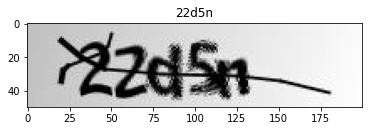

In [ ]:
plt.title(labels[1])
plt.imshow(img[:,:, 0].T, cmap='gray', vmin=0, vmax=255)
plt.plot()

### Model

In [ ]:
class CTC(layers.Layer):
    def __init__(self):
        super().__init__()
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred


def build_model():

    input_img = Input(shape=(img_width, img_height, 1), name="img_input")

    conv1 = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
    max_pool1 = MaxPooling2D((2, 2), name="pool1")(conv1)
    
    conv2 = Conv2D(64, (2, 2),activation="relu", padding="same")(max_pool1)
    max_pool2 = MaxPooling2D((2, 2))(conv2)

    reshape = Reshape((max_pool2.shape[1], max_pool2.shape[2] * max_pool2.shape[3]))(max_pool2)

    dense1 = Dense(100, activation="relu")(reshape)
    drop1 = Dropout(0.2)(dense1)
    dense2 = Dense(50, activation="relu")(drop1)
    drop2 = Dropout(0.2)(dense2)

    lstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25))(drop2)
    dense3 = Dense(len(vocabulary)+1, activation="softmax", name="out")(lstm)

    labels = Input(shape=(None, ))
    output = CTC()(labels, dense3)
    
    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output
    )
    
    return model   

### Train

In [ ]:
model = build_model()
model.compile(optimizer="adam")
model.fit((np.array(imgs), np.array(labels_int)), epochs=30, batch_size=16)

Epoch 1/30
65/65 [==============================] - 1s 16ms/step - loss: 26.4553
Epoch 2/30
65/65 [==============================] - 1s 16ms/step - loss: 16.3536
Epoch 3/30
65/65 [==============================] - 1s 17ms/step - loss: 16.3586
Epoch 4/30
65/65 [==============================] - 1s 16ms/step - loss: 16.3526
Epoch 5/30
65/65 [==============================] - 1s 16ms/step - loss: 16.3471
Epoch 6/30
65/65 [==============================] - 1s 16ms/step - loss: 16.3407
Epoch 7/30
65/65 [==============================] - 1s 16ms/step - loss: 16.3429
Epoch 8/30
65/65 [==============================] - 1s 16ms/step - loss: 16.3378
Epoch 9/30
65/65 [==============================] - 1s 16ms/step - loss: 16.3450
Epoch 10/30
65/65 [==============================] - 1s 16ms/step - loss: 16.3352
Epoch 11/30
65/65 [==============================] - 1s 16ms/step - loss: 16.3232
Epoch 12/30
65/65 [==============================] - 1s 18ms/step - loss: 16.3273
Epoch 13/30
65/65 [======

### Inference

In [ ]:
prediction_model = keras.models.Model(
    model.get_layer(name="img_input").input, model.get_layer(name="out").output
)

In [ ]:
predictions = prediction_model.predict(imgs_test)
invert_vocabulary = {v: k for k, v in vocabulary.items()}

In [ ]:
def decode(sequence):
  decoded = []
  text = ""
  i = 0
  pointeur = 0  
  while i<len(sequence):
    if sequence[i] != 19:
      decoded.append(sequence[i])
      text = text + invert_vocabulary[sequence[i]]
      pointeur = i 
      break     
    i += 1
     
  for i in range(pointeur+1, len(sequence)):
    if sequence[i-1] != sequence[i] and sequence[i] != 19:
      decoded.append(sequence[i])
      text = text + invert_vocabulary[sequence[i]]

  return decoded, text

In [ ]:
decoded_predictions = []

In [ ]:
for pred in predictions:
  max_indexes = [np.argmax(p) for p in pred]
  dec, text = decode(max_indexes)
  decoded_predictions.append(text)    

### Vizualizations to check accuracy of the model

In [ ]:
random_indexes = [random.randint(0, len(decoded_predictions)) for i in range(0,8)]
random_indexes

[3, 79, 97, 52, 95, 58, 78, 29]

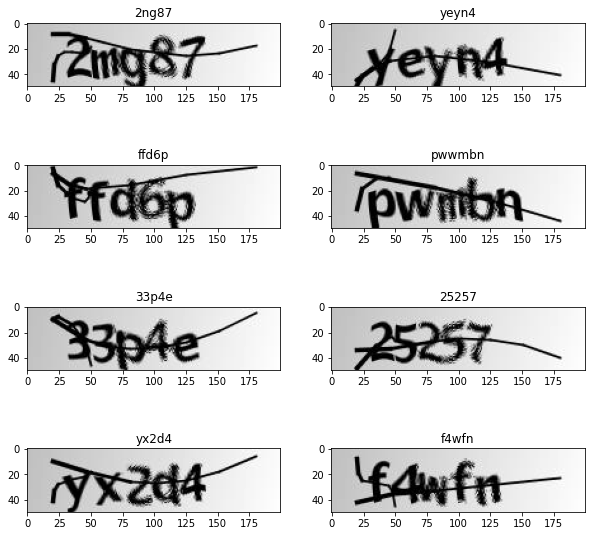

In [ ]:
plt.figure(figsize=(10,10))
base = 420
for i, index in enumerate(random_indexes):
  plt.subplot(base + i + 1)

  img = (imgs_test[index] * 255).astype("uint8")
  title = decoded_predictions[index]
  plt.imshow(img[:,:, 0].T, cmap='gray', vmin=0, vmax=255)
  plt.title(title)